# Accumulator

The accumulator will not improve the snr of the input spike trains, but will output a cleaner signal than would otherwise have been output at the same given rates.

What about the dynamics of the accumulator? will it add an additional dynamical unit into our feedback loops?

$$
\dot{x} = u
$$

$$u=\sum_i\sum_j d_i\delta(t-t_{i,j})$$

$i$ is neuron index and $j$ is spike index

$$
x = \sum_i\sum_j d_iH(t-t_{i,j})
$$

I'd like to know when $x$ will reach threshold. It seems like that depends on the input spike rates and their respective decoding weights.

$$x=\sum_i\sum_jd_iH(t-jT_i-T_{i,0})$$

all of the input spikes are uniform but with random offsets $T_{i,0}$

That is, $T_{i,0}\sim U[0,T_i]$

# Accumulator structure

The accumulator is 15 bits wide. Each weight from the weight memory is 8 bits wide. A 3 bit threshold value sets which bit in the accumulator will be used to detect an output spike.

Raising the threshold bit position increases the precision of the weight at the cost of the dynamic range.  Draw a picture.

When threshold position bit position is at its lowest position

<table>
    <tr>
        <th colspan=15>
            accumulator bit position
        </th>
    </tr>
    <tr>
        <td>14</td> <td>13</td> <td>12</td> <td>11</td> <td>10</td>
        <td>9</td> <td>8</td> <td>7</td> <td>6</td> <td>5</td>
        <td>4</td> <td>3</td> <td>2</td> <td>1</td> <td>0</td>
    </tr>
    <tr>
        <td colspan=7></td><th colspan=8>memory input</th>
    </tr>
    <tr>
        <td></td><th colspan=8>threshold bits</th><td colspan=6></td>
    </tr>
</table>

In [1]:
%matplotlib inline
from acc import Pool, SpikeTrain
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from nengo.utils.matplotlib import rasterplot as nengo_raster

from IPython.core.display import HTML
HTML(open("./styles/custom.css", "r").read())

In [2]:
def rasterplot(spike_trains, ax=None):
    """Wrap nengo rasterplot for this notebook
    Inputs
    ------
    spike_trains: SpikeTrain or list of spike_trains
    
    Outputs
    -------
    handle of axis used to plot
    """
    if type(spike_trains) is not list:
        spike_trains = [spike_trains]
    N = len(spike_trains)
    T = []
    for n in range(N):
        T.append(len(spike_trains[n].times))
    spikes = np.zeros((np.sum(T), N+1))
    
    idx0 = 0
    for n in range(N):
        idx1 = idx0 + T[n]
        spikes[idx0:idx1, 0] = spike_trains[n].times
        spikes[idx0:idx1, n+1] = 1
        idx0 = idx1
    
    time = spikes[:,0]
    spikes = spikes[:,1:]
    
    return nengo_raster(time, spikes, ax=ax)

In [3]:
def run_experiment(N, input_rates, weights, thresheld, T=1.):
    pool = Pool(N=N, spike_rates=input_rates, weights=weights, threshold=threshold)
    spks_in = pool.gen_nrn_spikes(T=T)
    merged_spks_in = pool.merge_spikes(spks_in)
    spks_out, acc_state = pool.gen_acc_spikes(merged_spks_in)
    return spks_in, acc_state, spks_out

def plot_timeseries(spks_in, acc_state, spks_out, tmin=None, tmax=None):
    fig, axs = plt.subplots(nrows=3, figsize=(12,9), sharex=True)
    rasterplot(spks_in, axs[0])
    axs[1].plot(acc_state.time, acc_state.state)
    axs[1].axhline(threshold, color='r')
    axs[1].axhline(-threshold, color='r')
    rasterplot(spks_out, axs[2])
    # set xlims
    axs[2].set_xlim([0, axs[2].get_xlim()[1]])
    if tmin:
        axs[2].set_xlim([tmin, axs[2].get_xlim()[1]])
    if tmax:
        axs[2].set_xlim([axs[2].get_xlim()[0], tmax])
    axs[2].set_xlabel('Time')
    axs[0].set_title('Accumulator Input Spikes')
    axs[1].set_title('Accumulator State')
    axs[2].set_title('Accumulator Output Spikes')

def plot_isi(spks, bins=50):
    out_isi = np.diff(spks.times)
    fig, ax = plt.subplots(nrows=1, figsize=(8,3))
    n, bins, patches = ax.hist(out_isi, bins)
    ax.set_title('Output ISI Histogram')
    ax.set_xlabel('Time')
    ax.set_ylabel('Counts')

parameters to vary:
* number of neurons: 1,2,50,100,200
* weight distributions all: pos, mixed
* input neuron process: regular spiking, poisson spiking 

# Setting threshold

* pick an $f_{max}$
* represent $x=c\times f_{max}$ so that $x$ in $[-1:1]$ maps to firing rates in $[-f_{max}:f_{max}]$

The chip does not communicate in terms of real numbers, but rather spikes. We'll need to map the low-dimensional quantity $x$ to some spike rate $f$. Spikes can be signed. Something like

$$
f=f_{max}x
$$

so that for $x$ ranging in $[-1:1]$ (typical in nengo) we get an $f_{max}$ ranging in $[-f_{max}:f_{max}]$.

Each spike in to the accumulator will be weighted and added to the running sum. Assuming that the accumulator is always driven towards the positive or negative threshold, the value accumulated over a certain period of time will be given by

$$
\frac{\textrm{spikes_in}}{\textrm{s}}\cdot\frac{\textrm{weight}}{\textrm{spike_in}}\cdot \textrm{time} = \textrm{value accumulated}
$$

We can then apply the threshold to find the number of threshold crossings, or output spikes.

$$
\frac{\textrm{value accumulated}}{\textrm{threshold}}=\textrm{# threshold crossings}=\textrm{spikes out}
$$

To find the output rate, we divide the number of spikes out by the time

$$
\frac{\textrm{spikes out}}{\textrm{time}}=\frac{\textrm{spikes_in}}{\textrm{s}}\cdot\frac{\textrm{weight}}{\textrm{spike_in}}\cdot\frac{1}{\textrm{threshold}}
$$

for $N$ neurons spiking at rates $a_n$ with weights $d_n$ and accumulator with threshold $k$, we can formalize the previous discussion in the following equation

$$
\frac{\sum_{n=1}^Na_nd_n}{k} = f_{out}
$$

which implies that

$$
\sum_{n=1}^Na_nd_n = f_{out}k
$$

That is, we should set our decode weights and accumulator threshold appropriately by the above relationship. 

In this notebook, we'll go for a target spike rate of 1000.

# Single neuron

Let's test the accumulator with a single neuron. The accumulator can only decimate the incoming spikes, so we won't be able to reach 1000.

First we consider when the neuron's weight is a multiple of the threshold

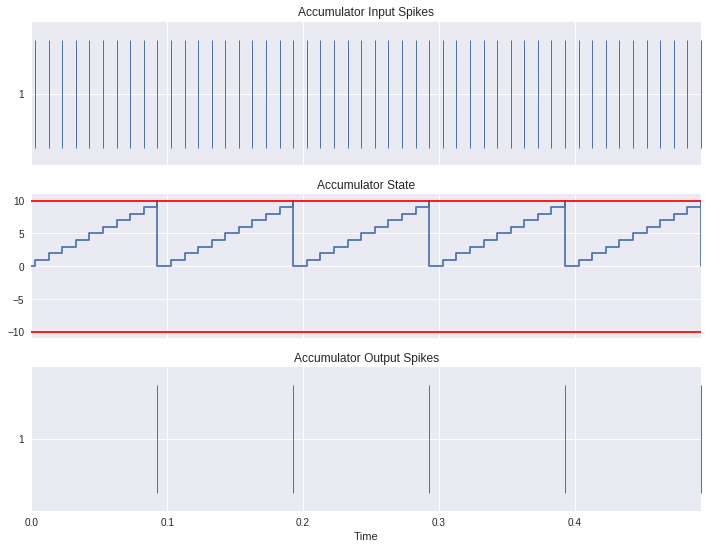

In [4]:
N = 1
input_rates = 100
weights = 1
threshold = 10
spks_in, acc_state, spks_out = run_experiment(
    N=N, input_rates=input_rates, weights=weights, thresheld=threshold, T=0.5)
plot_timeseries(spks_in, acc_state, spks_out)

As we expect, all of the output inter-spike intervals are the same. The accumulator simply decimates the traffic by the weight. A synapse receiving input from an accumulator would have the same statistics as one receiving input from a regularly spiking neuron of the same rate.

Don't take it for granted that the accumulator will improve signal quality. or will it?
try building an equivalent output rate from the same number of regular spiking input neurons.

Next we show that an accumulator can degrade the signal quality even when controlling rate. When the neuron's weight is not a divisor of the threshold, there is variation in the output ISI.

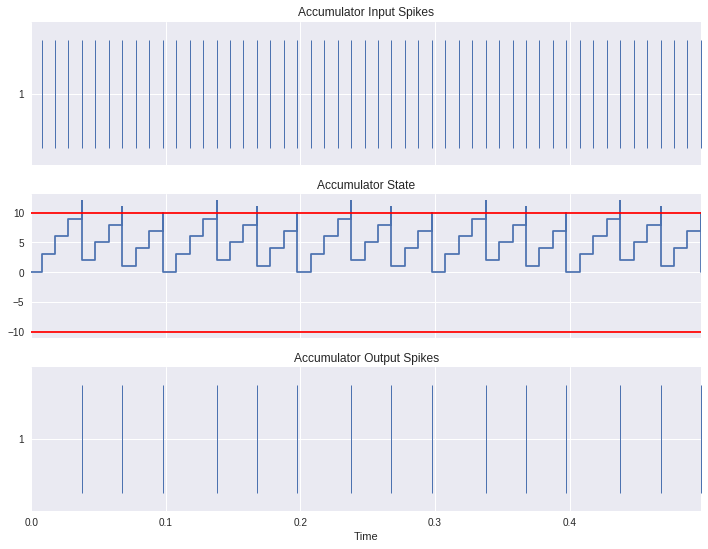

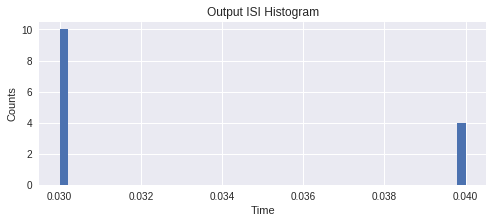

In [5]:
N = 1
input_rates = 100
weights = 3
threshold = 10
spks_in, acc_state, spks_out = run_experiment(
    N=N, input_rates=input_rates, weights=weights, thresheld=threshold, T=0.5)
plot_timeseries(spks_in, acc_state, spks_out)
plot_isi(spks_out, bins=50)

In this case, the output ISI will be variable

# Many Neurons, Regular Spiking, Random Weights

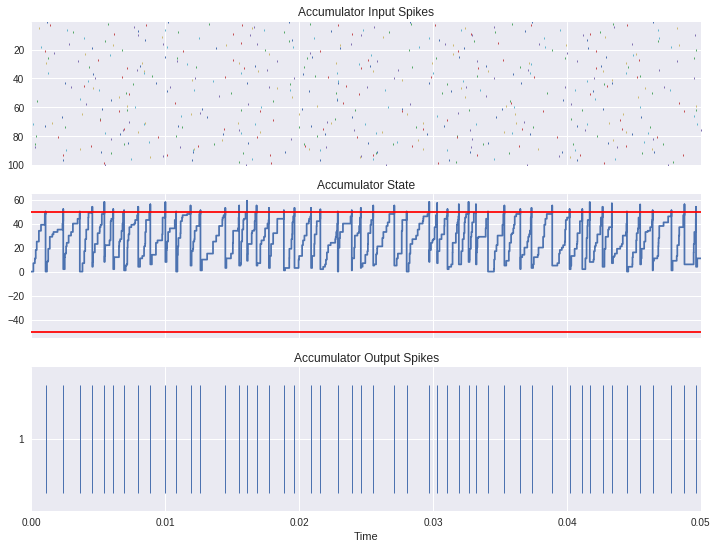

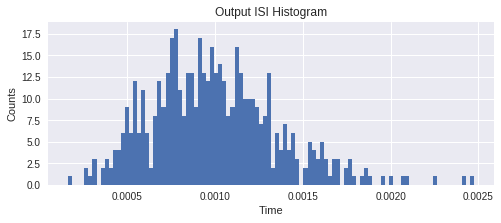

In [6]:
N = 100
input_rates = np.random.uniform(50, 150, size=N)
weights = np.random.randint(0, 11, size=N)
threshold = int(np.sum(input_rates*weights)/1000.)
T=10
spks_in, acc_state, spks_out = run_experiment(
    N=N, input_rates=input_rates, weights=weights, thresheld=threshold, T=0.5)
plot_timeseries(spks_in, acc_state, spks_out, tmax=0.05)
plot_isi(spks_out, bins=100)

5


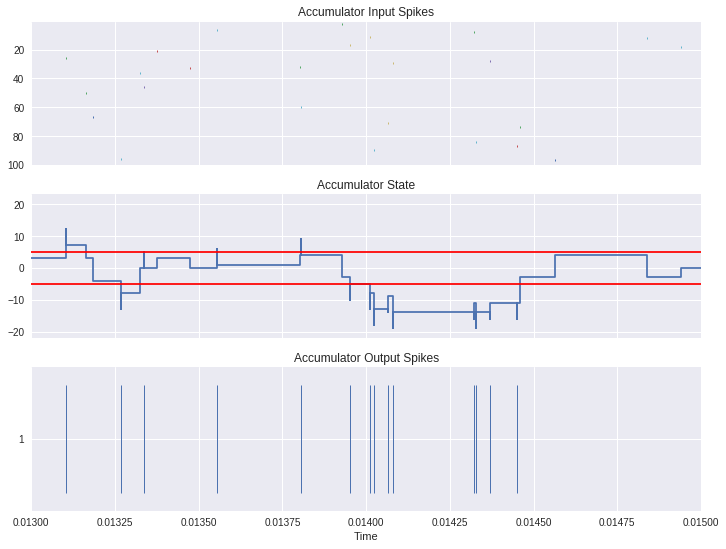

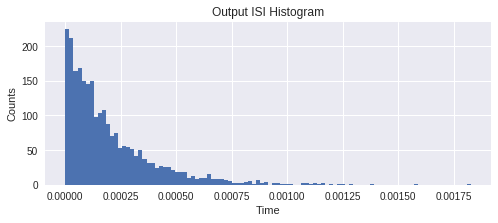

In [7]:
N = 100
np.random.seed(0)
input_rates = np.random.uniform(0, 200, size=N)
weights = np.random.randint(-10, 10, size=N)
threshold = int(np.abs(np.sum(input_rates*weights))/1000.)
print(threshold)
T=10
spks_in, acc_state, spks_out = run_experiment(
    N=N, input_rates=input_rates, weights=weights, thresheld=threshold, T=0.5)
plot_timeseries(spks_in, acc_state, spks_out, tmin=0.013, tmax=0.015)
plot_isi(spks_out, bins=100)

# Appendix

In [8]:
# check that threshold scaling works
fmax = 500.
for n in [10, 20, 30, 40, 50, 100, 200]:
    input_rates = np.random.uniform(0, 400, size=N)
    weights = np.random.randint(0, 11, size=N)
    threshold = int(np.sum(input_rates*weights)/fmax)
    T=10
    spks_in, acc_state, spks_out = run_experiment(
        N=N, input_rates=input_rates, weights=weights, thresheld=threshold, T=0.5)
    print("avg output spike rate = %f" % (1./np.mean(np.diff(spks_out.times))))

avg output spike rate = 500.151170
avg output spike rate = 501.001343
avg output spike rate = 501.996749
avg output spike rate = 501.184326
avg output spike rate = 500.154459
avg output spike rate = 499.554544
avg output spike rate = 500.310826
